In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import yaml
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, AutoEmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
from dwave_networkx.algorithms.coloring import min_vertex_color, is_vertex_coloring
import time

In [3]:
q_sampler = AutoEmbeddingComposite(DWaveSampler(token='DEV-076b8a03c140ad9291e859ef02ab3403afc91429'))

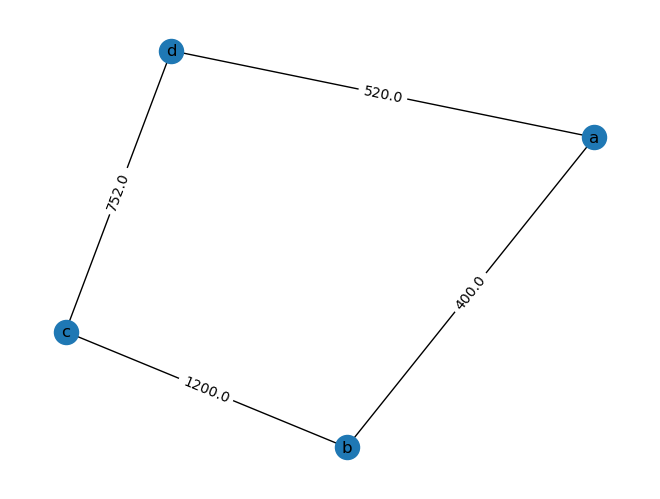

In [ ]:
def plot_graph(filename):

    G = nx.read_weighted_edgelist(filename)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()
    return G
G=plot_graph("networks/graph2.txt")


In [5]:
def generate_demands(G):
    demands = {}
    for a in G.nodes:
        for b in G.nodes:
            if b == a:
                pass
            else:
                x = random.randrange(0, 3, 1)
                if x == 0:
                    demands[(a, b)] = 10
                elif x == 1:
                    demands[(a, b)] = 40
                else:
                    demands[(a, b)] = 100
    return demands
demands={('a', 'b'): 40, ('a', 'c'): 10, ('a', 'd'): 100, ('b', 'a'): 10, ('b', 'c'): 100, ('b', 'd'): 100, ('c', 'a'): 100, ('c', 'b'): 100, ('c', 'd'): 100, ('d', 'a'): 100, ('d', 'b'): 10, ('d', 'c'): 100}
#demands=generate_demands(G)

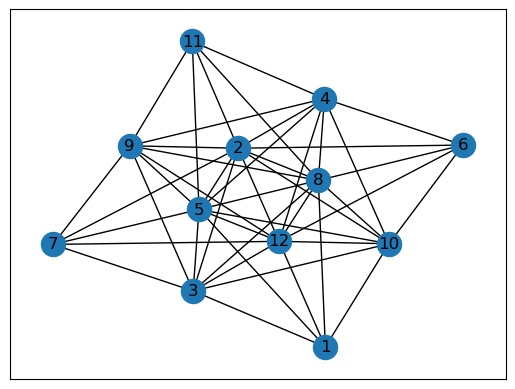

In [27]:
def create_graph(filepath, Graph, demands):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    converted_graph = nx.Graph()
    s_d_label = 0
    label = 0
    for a in network_data:
        s_d_label += 1
        source = network_data[a]["source"]
        destination = network_data[a]["destination"]
        rate = demands[(source, destination)]
        for i in network_data[a]["routes"]:
            label += 1
            nodes_in_path = i
            edges_in_path = []
            total_weight = 0
            for j in range(len(i) - 1):
                edges_in_path.append((nodes_in_path[j], nodes_in_path[j + 1]))
                edges_in_path.append((nodes_in_path[j+1], nodes_in_path[j])) # remove if direction of light matters.
                total_weight += Graph[nodes_in_path[j]][nodes_in_path[j + 1]]["weight"]
            converted_graph.add_node(label, s_d=s_d_label, r=rate,w=total_weight,edges=edges_in_path)
    x=converted_graph.number_of_nodes()
    for a in range(1,x):
        for b in range(a+1,x+1):
            if converted_graph.nodes[a]["s_d"] != converted_graph.nodes[b]["s_d"]: # don't want connection between same routes- then each one affects the others selection
                for j in converted_graph.nodes[a]["edges"]:
                    for i in converted_graph.nodes[b]["edges"]:
                        if i == j:
                            converted_graph.add_edge(a,b)
                            break
                    else:
                        continue
                    break
                        
                        
    return converted_graph

new_graph=create_graph("networks/graph2-conversion.yaml",G,demands)
nx.draw_networkx(new_graph)


In [10]:
def create_qubo(Graph,c1,c2,c3):
    Q={}
    adj_matrix=nx.adjacency_matrix(Graph)
    dense_matrix=adj_matrix.todense()
    set_of_nodes=Graph._node
    for a in set_of_nodes:
        for b in set_of_nodes:
            if Graph.nodes[a]["s_d"]==Graph.nodes[b]["s_d"]:
                if a==b:
                    Q[(a,b)]=-c1
                else:
                    Q[(a,b)]=2*c1
            elif dense_matrix[a-1][b-1]==1:
                Q[(a,b)]=c2
            else:
                Q[(a,b)]=0
    
    for a in set_of_nodes:
        length=Graph.nodes[a]["w"]    
        if Graph.nodes[a]["r"]==10:
            max_d=1680
            if length>max_d:
                Q[(a,a)]+=c3
        else:
            neighbours=list(Graph.neighbors(a))
            affecting_neighbours=[]
            for i in neighbours:
                if Graph.nodes[i]["r"]==10:
                    affecting_neighbours.append(i)
            
            if Graph.nodes[a]["r"]==40:
                max_d=1301
                penalty=131
            elif Graph.nodes[a]["r"]==100:
                max_d=1430
                penalty=370
            
            if length>max_d:
                Q[(a,a)]+=c3
            elif length>(max_d-penalty):
                for i in affecting_neighbours:
                    Q[(a,i)]+=c3

    return Q
            
QUBO = create_qubo(new_graph,1,0.01,3.5)


bqm= BinaryQuadraticModel.from_qubo(QUBO)

In [22]:
def solve_qubo(bqm,sampler=SimulatedAnnealingSampler(),num_runs=1):
    sampleset= sampler.sample(bqm,num_reads=num_runs,label= "Routing QUBO solving")
    return sampleset

result=solve_qubo(bqm,q_sampler)
print(result)


   1  2  3  4  5  6  7  8  9 10 11 12 energy num_oc. chain_.
0  1  0  0  1  0  1  1  0  0  1  1  0   -5.9       1     0.0
['BINARY', 1 rows, 1 samples, 12 variables]


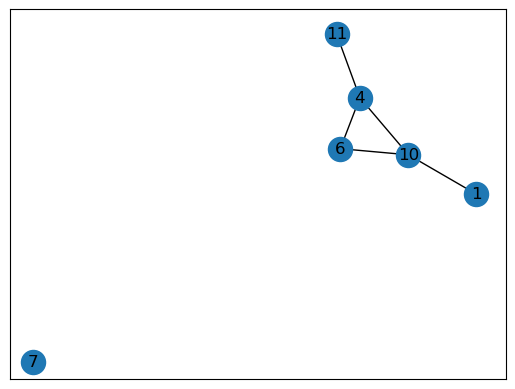

In [30]:
solution_values=[]
for variable in range(1,13):
    solution_values.append(int(result.first.sample[variable]))
for i in range(12):
    if solution_values[i]==0:
        new_graph.remove_node(i+1)


nx.draw_networkx(new_graph)

In [45]:
def solve_graph_coloring_annealing(G, sampler, attempts=3):
    start_time = time.time()
    for i in range(attempts):        
        solution = min_vertex_color(G, sampler=sampler, label="GCP")
        try:
            if is_vertex_coloring(G, solution):
                end_time = time.time()
                wavelengths = len(set(solution.values()))
                return {
                    "valid": True,
                    "num_colors": wavelengths,
                    "time_taken": end_time - start_time,
                    "solution": solution
                }
            print(f"[-] Attempt {i} failed")
        except KeyError:
            continue
    return "timeout"
colouring=solve_graph_coloring_annealing(new_graph,q_sampler)
print(colouring)

{'valid': True, 'num_colors': 3, 'time_taken': 2.7479186058044434, 'solution': {1: 1, 4: 0, 6: 1, 7: 1, 10: 2, 11: 2}}


3


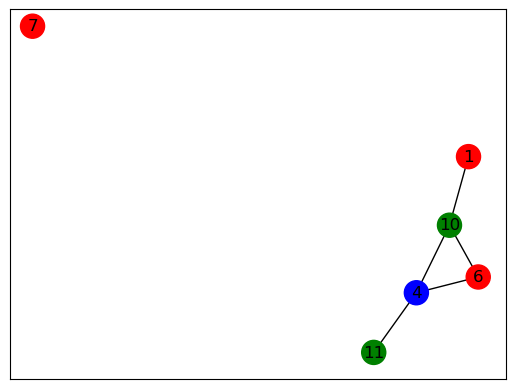

In [48]:
selected_colours=colouring["solution"]
colours=["blue","red","green","brown","purple","orange","pink","gray","olive","cyan"]
color_map=[]
for a in selected_colours:
    color_map.append(colours[selected_colours[a]])
print(colouring["num_colors"])
nx.draw_networkx(new_graph,node_color=color_map)


In [101]:
correct_solution=[1,0,0,1,0,1,1,0,0,1,1,0]
runs=10
solved_cases=0
time_taken=0
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,13):
        solution_outcomes.append(solution.first.sample[variable])
    if solution_outcomes==correct_solution:
        solved_cases+=1

print(solved_cases/runs,time_taken/runs)   

1.0 0.008592249965295196


In [95]:
QUBO = create_qubo(new_graph,1,0.01,3.5)


bqm= BinaryQuadraticModel.from_qubo(QUBO)
correct_solution=[1,0,0,1,0,1,1,0,0,1,1,0]
runs=10
solved_cases=0
time_taken=0
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm,q_sampler)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,13):
        solution_outcomes.append(solution.first.sample[variable])
    if solution_outcomes==correct_solution:
        solved_cases+=1

print(solved_cases/runs,time_taken/runs)   

0.9 0.19863305003382264
